In [79]:
%load_ext autoreload
%autoreload 2

In [1]:
import os,sys
import shutil
import re
import json
import numpy as np
import pandas as pd
import audiofile
from tqdm import tqdm
import datetime
import copy

import seaborn as sns
import matplotlib.pyplot as plt
import IPython

In [2]:
import scipy.signal as sig 
import sklearn.preprocessing as skp # RobustScaler, StandardScaler
from sklearn.utils.validation import check_is_fitted

import mne
#%matplotlib qt

In [3]:
video_path = "../data/video"
aaudio_folder = "../data/audio-aligned"
eeg_folder = "../data/eeg"
teeg_folder = "../data/eeg-aligned"
e4_folder = "../data/empatica"
skip_sessions = []
markers_path = "../data/video/markers_from_video_start.csv"
markers = pd.read_csv(markers_path)
sq_path = "../data/video/cadrage-video.xlsx"
signal_quality = pd.read_excel(sq_path, sheet_name="Signal Quality")

In [4]:
# get bad channel dataframe
signal_quality.Impedence_High = signal_quality.Impedence_High.apply(lambda x: [] if isinstance(x,float) else ([f"{l}{n}" for l in ['A','B'] for n in range(1,33)] if x == 'all' else x.split(',')))
signal_quality.Saturating = signal_quality.Saturating.apply(lambda x: [] if isinstance(x,float) else ([f"{l}{n}" for l in ['A','B'] for n in range(1,33)] if x == 'all' else x.split(',')))
# only labelling Saturating as 'bad' channels
signal_quality['bad_channels'] = signal_quality.apply(lambda x: [f"{x.AdBox}-{ch}" for ch in x.Saturating], axis=1)
# ---- result
bad_ch = signal_quality.groupby(['Date','Dyad']).agg({'bad_channels': 'sum'})

## Tests

In [5]:
# depends on which AdBox - swap 'EXG' rule
def drop_ch_rules(ch_name:str) -> bool:
    if '-C' in ch_name or '-D' in ch_name:
        return True
    elif 'EXG' in ch_name:
        if '1-' in ch_name and int(ch_name[-1]) not in [1,2,3]:
            return True
        if '2-' in ch_name and int(ch_name[-1]) not in [4,5,6]:
            return True
    elif ch_name[2:5] in ['GSR','Erg'] or ch_name[2:] in ['Resp','Plet','Temp']:
        return True 
    return False

In [241]:
vfolder = "221123_YAEB"
[date, group] = vfolder.split("_")
video_export = f"bkt-{date}-{group}.mov"
vaudio_name = f"bkt-{date}-{group}.wav"
raudio_name = f"bkt-{date}-{group}_rme.wav"
eeg_name = f"brainkt_{date}_{group}.bdf"
mark = markers.loc[markers.file == vfolder].iloc[0]

# load audio from video
vaudio, vfs = audiofile.read(os.path.join(aaudio_folder, vaudio_name))

# load audio from RME
raudio, rfs = audiofile.read(os.path.join(aaudio_folder, raudio_name))

# load EEG
data = mne.io.read_raw_bdf(os.path.join(eeg_folder, eeg_name), preload=True) # mne as relative
data = data.drop_channels([x for x in data.ch_names if drop_ch_rules(x)])
#data = data.drop_channels([x for x in data.ch_names if '-C' in x or '-D' in x or ('EXG' in x and int(x[-1]) not in list(range(1,7)) )])
data.set_channel_types({x:'misc' for x in data.ch_names if ('-A' not in x) and ('-B' not in x) and ('Status' not in x)})
# data.set_eeg_reference([x for x in data.ch_names if 'EXG' in x])
data.info['bads'] = bad_ch.loc[(int(date),group),'bad_channels']
data.info['meas_date'], data.info['sfreq'], data.info['nchan']

Extracting EDF parameters from /Users/eliot/Documents/projects/brainkt-expe/data/eeg/brainkt_221123_YAEB.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4087807  =      0.000 ...  1996.000 secs...


(datetime.datetime(2022, 11, 23, 17, 0, 7, tzinfo=datetime.timezone.utc),
 2048.0,
 135)

In [8]:
data.info

<Info | 8 non-empty values
 bads: 1 items (2-B25)
 ch_names: 1-A1, 1-A2, 1-A3, 1-A4, 1-A5, 1-A6, 1-A7, 1-A8, 1-A9, 1-A10, ...
 chs: 128 EEG, 6 BIO, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2022-11-23 17:00:07 UTC
 nchan: 135
 projs: []
 sfreq: 2048.0 Hz
>

In [242]:
markers_idx = mne.find_events(data, stim_channel='Status')
# Only one type of events, next steps are dropped
#markers_idx[np.where(markers_idx[:,2] == 1)[0]]
#mne.pick_events(markers_idx, include=[1])
# Note: only the first event is extracted - but actually ~ 0.5s is given
markers_idx

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
5 events found
Event IDs: [1]


array([[ 156069,       0,       1],
       [2105247,       0,       1],
       [2106382,       0,       1],
       [4076441,       0,       1],
       [4080507,       0,       1]])

In [6]:
def drop_markers(data, stim_channel:str='Status', repeat_window:float=5., replace_value:int=0):
    """Locate markers that are within a window of the previous marker and drop them.
    """
    # 1. Locate markers
    sfreq = data.info['sfreq']
    markers_idx = mne.find_events(data, stim_channel=stim_channel)
    markers_idx = pd.DataFrame(markers_idx, columns=['idx','init_val','end_val']) # fillna with a value that won't be dropped
    markers_idx['within_window'] = (markers_idx.idx - markers_idx.idx.shift()).fillna(-repeat_window*sfreq) > repeat_window*sfreq 
    markers_idx['within_window'] = markers_idx['within_window'].cumsum()
    keep_markers = markers_idx.drop_duplicates(['init_val','end_val','within_window']).idx.tolist()
    print("Dropping markers at index: ", set(markers_idx.idx.tolist()) - set(keep_markers))
    # 2. Replace markers
    for i in keep_markers:
        event_start = i + int(0.2*sfreq)
        event_end = event_start + int(repeat_window*sfreq)
        data['Status',event_start:event_end] = replace_value
    # Inplace, no return
    return keep_markers

In [249]:
markers_idx = drop_markers(data)
mne.find_events(data, stim_channel='Status')
markers_idx

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3 events found
Event IDs: [1]
Dropping markers at index:  {4080507, 2106382}
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3 events found
Event IDs: [1]


[156069, 2105247, 4076441]

In [252]:
[x/2048 for x in markers_idx]

[76.20556640625, 1027.95263671875, 1990.44970703125]

In [ ]:
dt = data.to_data_frame()
dt.head()

In [12]:
dt.loc[[ 156069,2105247,2106382,4076441,4080507]]['time']

156069       76.205566
2105247    1027.952637
2106382    1028.506836
4076441    1990.449707
4080507    1992.435059
Name: time, dtype: float64

In [142]:
mark

file                 221123_YAEB
Start                        0.0
Watch p1                    0.44
Watch p2                    4.04
Clap                        20.8
Start Task 1                30.8
End Task 1                982.56
End Task 2               1945.04
Stop                      1948.0
Actual End Task 1            NaN
Name: 9, dtype: object

In [119]:
m = 'Start Task 1'
#m = 'End Task 1'
#m = 'End Task 2'

audio_trigger = int(mark[m]*vfs)
swindow = int(0.5*vfs) # 1s window
wsr = audio_trigger - swindow
wst = audio_trigger + swindow

<Figure size 640x480 with 0 Axes>

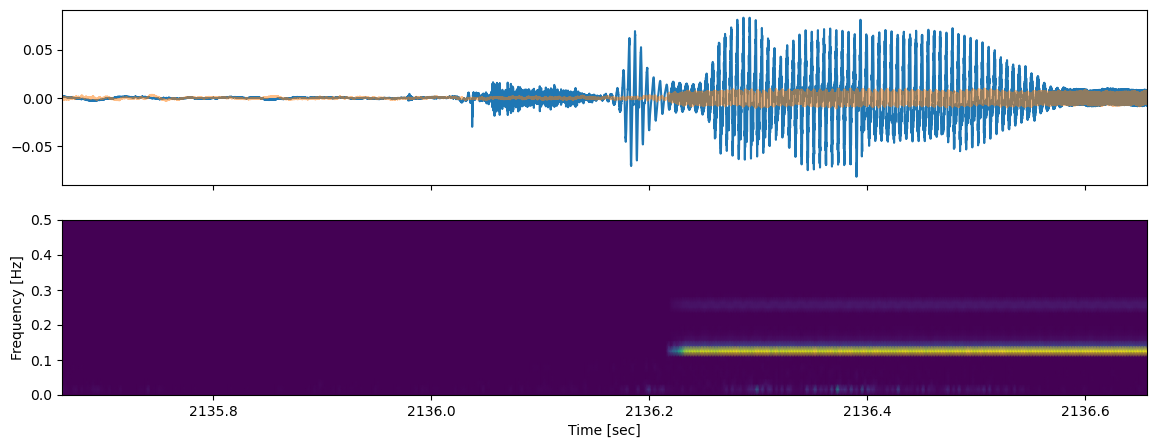

In [120]:
plt.clf()
fig, ax = plt.subplots(nrows=2, figsize=(14,5), sharex=True)
# plot soundwave
ts = np.array(range(wsr,wst))/vfs
ax[0].plot(ts, vaudio[0,wsr:wst])
ax[0].plot(ts, vaudio[1,wsr:wst], alpha=0.5)
# plot spectrogram
f, t, Sxx = sig.spectrogram(vaudio[1,wsr:wst], nfft = 64, nperseg=64) 
# noverlap: want the closest thing so based on vfs again
# eeg fs = 2048 
# vfs/2048 = 10.7666015625 if vfs = 22050
plt.pcolormesh((t+wsr)/vfs, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Same but with scaling:

In [121]:
adf = pd.DataFrame(vaudio[:,wsr:wst].T, index=ts, columns=['cam1','cam2'])

if m == "Start Task 1": # only fit for first marker
    sc = {  'cam1': skp.StandardScaler().fit(vaudio[0,wsr:wst].reshape(-1, 1)), 
            'cam2': skp.StandardScaler().fit(vaudio[1,wsr:wst].reshape(-1, 1))}
adf['cam1'] = sc['cam1'].transform(adf['cam1'].to_numpy().reshape(-1, 1))
adf['cam2'] = sc['cam2'].transform(adf['cam2'].to_numpy().reshape(-1, 1))
adf[adf.cam1.abs() > 1.5].head() # issues without normalisation

,cam1,cam2
2135.979909,1.583937,-0.077448
2136.027302,-1.563652,-0.168444
2136.027347,-1.516957,-0.130276
2136.027483,-1.512306,-0.024795
2136.027664,-1.633177,0.073152


In [108]:
trig_spec = pd.DataFrame(Sxx, index=f, columns=(t+wsr)/vfs) # in s, t*vfs + wsr for samples index
#trig_spec.T.idxmax(axis=1) # 0.125000
#trig_spec.loc[0.125000].T.plot() # > 0.0005
snd = trig_spec.loc[0.125000].T 
snd[snd > 0.0005].head() # starting with the first

1074.541451    0.000509
1074.919864    0.000760
1074.922404    0.002308
1074.924943    0.002126
1074.927483    0.002227
Name: 0.125, dtype: float32

<AxesSubplot:>

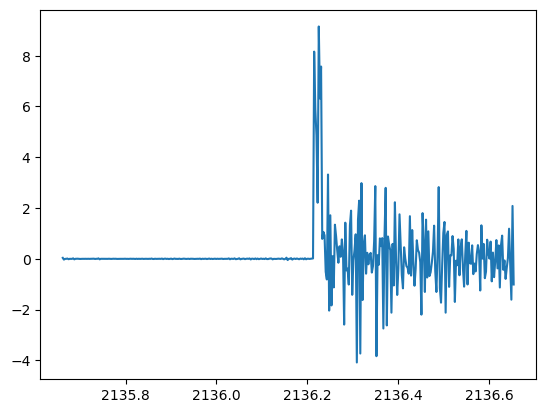

In [127]:
trig_spec.loc[0.125000].T.diff().shift(-1) > 0.5

<Figure size 640x480 with 0 Axes>

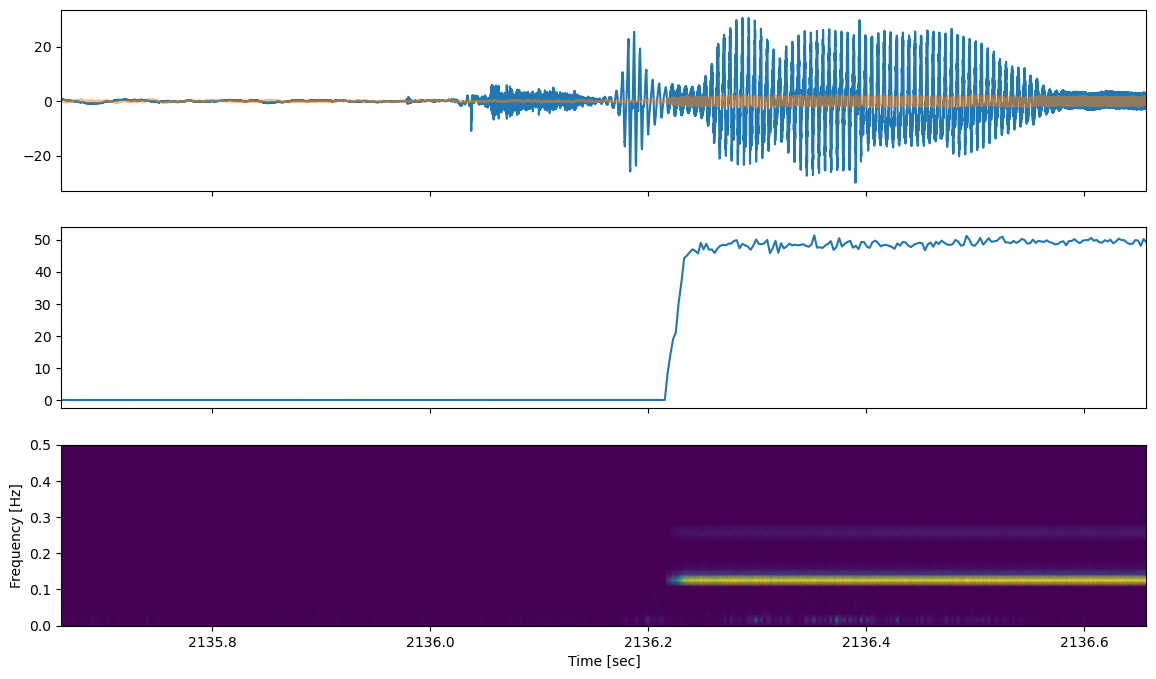

In [123]:
plt.clf()
fig, ax = plt.subplots(nrows=3, figsize=(14,8), sharex=True)
# plot soundwave
ts = np.array(range(wsr,wst))/vfs
ax[0].plot(ts, adf.cam1)
ax[0].plot(ts, adf.cam2, alpha=0.5)
# plot spectrogram
f, t, Sxx = sig.spectrogram(adf.cam2, nfft = 64, nperseg=64) 
trig_spec = pd.DataFrame(Sxx, index=f, columns=(t+wsr)/vfs) # in s, t*vfs + wsr for samples index
trig_spec.loc[0.125000].T.plot(ax=ax[1]) # > 0.0005
plt.pcolormesh((t+wsr)/vfs, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [7]:
def get_audio_trig(vaudio:np.array, marks:pd.Series, fs:float, 
                    spec_nfft:int=64, spec_target_fq:float=0.12500, win_side:float=0.5,
                    add_plots:bool=False, add_durations:bool=True) -> pd.DataFrame:
    audio_trig = []
    sc = { 'cam1': skp.StandardScaler(), 'cam2': skp.StandardScaler() }
    for trig in ['Start Task 1','End Task 1','End Task 2']:
        at = {'marker': trig, 'video_time': mark[trig]}
        # parameters
        audio_trigger = int(mark[trig]*fs)
        swindow = int(win_side*fs) # 1s window if win_side = 0.5
        wsr = audio_trigger - swindow
        wst = audio_trigger + swindow
        # ----- locate in signal (won't work if too noisy)
        ts = np.array(range(wsr,wst))/fs
        adf = pd.DataFrame(vaudio[:,wsr:wst].T, index=ts, columns=['cam1','cam2'])
        try: # scale - use the same scaling for all 3 markers
            check_is_fitted(sc['cam1'])
        except: # NotFittedError
            sc['cam1'].fit(vaudio[0,wsr:wst].reshape(-1, 1))
            sc['cam2'].fit(vaudio[1,wsr:wst].reshape(-1, 1))
        # scale
        adf['cam1'] = sc['cam1'].transform(adf['cam1'].to_numpy().reshape(-1, 1))
        adf['cam2'] = sc['cam2'].transform(adf['cam2'].to_numpy().reshape(-1, 1))
        # 
        at['p1-sig_time'] = adf[adf.cam1.abs() > 1.5].index.tolist()[0]
        at['p2-sig_time'] = adf[adf.cam2.abs() > 1.5].index.tolist()[0]
        # ----- locate in spectrogram
        for ch in [1,2]:
            # parameters for spectrogram: nfft = nperseg = 64 => target frequency = 0.125000
            # also issues if scaling not applied
            f, t, Sxx = sig.spectrogram(adf[f'cam{ch}'], nfft = spec_nfft, nperseg=spec_nfft) # vaudio[ch,wsr:wst]
            trig_spec = pd.DataFrame(Sxx, index=f, columns=(t+wsr)/fs)
            snd = trig_spec.loc[spec_target_fq].T 
            at[f'p{ch}-spec_time'] = snd[snd > 40].index.tolist()[0] # 0.0005 if not scaling
            #sndd = snd.diff().shift(-1)
            #sndd[sndd > 0.5].index.tolist()[0]
        # add to list
        audio_trig.append(at)
        # ----- XXX: check that audio in the signal doesn't affect (for instance, looking for _periods_ above a threshold)

    audio_trig = pd.DataFrame(audio_trig).set_index('marker')
    # Booleans
    if add_durations:
        # differences in measurements
        audio_trig['st-diff'] = audio_trig['p1-sig_time'] - audio_trig['p2-sig_time']
        audio_trig['sp-diff'] = audio_trig['p1-spec_time'] - audio_trig['p2-spec_time']
        # tasks durations
        durations = pd.concat([audio_trig.loc['End Task 1'] - audio_trig.loc['Start Task 1'], 
            audio_trig.loc['End Task 2'] - audio_trig.loc['End Task 1']], axis=1).T
        durations.index = ['Task 1', 'Task 2']
        durations.loc[:,['st-diff','sp-diff']] = np.nan
        # concatenate
        audio_trig = pd.concat([audio_trig, durations], axis=0)
    if add_plots:
        plt.clf()
        fig, ax = plt.subplots(nrows=2, figsize=(14,5), sharex=True)
        # plot soundwave
        ax[0].plot(ts, vaudio[0,wsr:wst])
        ax[0].plot(ts, vaudio[1,wsr:wst], alpha=0.5)
        # plot spectrogram
        plt.pcolormesh((t+wsr)/fs, f, Sxx, shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
    return audio_trig

In [201]:
audio_trig = get_audio_trig(vaudio, mark, vfs)
audio_trig

,video_time,p1-sig_time,p2-sig_time,p1-spec_time,p2-spec_time,st-diff,sp-diff
Start Task 1,60.24,60.253333,60.252336,60.254467,60.254467,0.000998,0.000000
End Task 1,1089.52,1089.139501,1089.193605,1089.214467,1089.557324,-0.054104,-0.342857
End Task 2,1962.12,1961.649751,1962.130295,1962.131927,1962.131927,-0.480544,0.000000
Task 1,1029.28,1028.886168,1028.941270,1028.960000,1029.302857,NaN,NaN
Task 2,872.60,872.510249,872.936689,872.917460,872.574603,NaN,NaN


In [168]:
get_audio_trig(raudio, mark, rfs)

,video_time,p1-sig_time,p2-sig_time,p1-spec_time,p2-spec_time,st-diff,sp-diff
Start Task 1,164.20,164.238413,164.240499,164.239819,164.242358,-0.002086,-0.002540
End Task 1,1074.88,1074.930068,1074.382404,1074.930023,1074.930023,0.547664,0.000000
End Task 2,2136.16,2136.000408,2135.660000,2136.240499,2136.253197,0.340408,-0.012698
Task 1,910.68,910.691655,910.141905,910.690204,910.687664,NaN,NaN
Task 2,1061.28,1061.070340,1061.277596,1061.310476,1061.323175,NaN,NaN


In [202]:
[x/2048 for x in markers_idx]
(markers_idx[1] - markers_idx[0])/2048, (markers_idx[2] - markers_idx[1])/2048
#1027.95263671875-76.20556640625, 1990.44970703125-1027.95263671875
# ==> using p1-spec_time to align

(1029.30419921875, 872.55126953125)

In [8]:
def check_durations(audio_trig:pd.Series, eeg_markers:list, eeg_sfreq:int, precision:float=1e-3, 
                    check_consistency:bool=False, **kwargs):
    eeg_task1 = (eeg_markers[1] - eeg_markers[0])/eeg_sfreq
    eeg_task2 = (eeg_markers[2] - eeg_markers[1])/eeg_sfreq
    dt1 = (abs(eeg_task1 - audio_trig.loc['Task 1']))
    dt2 = (abs(eeg_task2 - audio_trig.loc['Task 2']))
    # if issues raise error
    if dt1 > precision or dt2 > precision:
        raise ValueError(f'Durations are very different - check signal quality. Task 1: {dt1} - Task 2: {dt2} - Precision {precision}')
    
    # else returns padding/trim needed to align
    # note: aligning on second marker to avoid difference at the end
    val = eeg_markers[1]/eeg_sfreq - audio_trig.loc['End Task 1']
    d = {1:'trim',-1:'pad'}
    if check_consistency: # comparing columns
        return {'precision': precision, 'dt1': dt1, 'dt2': dt2}
    # otherwise return for pipeline
    print("(Precision, Task 1 Difference, Task 2 Difference): ", (precision, dt1, dt2))
    return {'pad_or_trim': d[np.sign(val)], 'duration': abs(val), 'n_': abs(int(np.ceil(val*eeg_sfreq)))}
    

In [204]:
dpt = check_durations(audio_trig["p2-spec_time"], markers_idx, data.info['sfreq'], precision=5e-2)
dpt

(Precision, Task 1 Difference, Task 2 Difference):  (0.05, 0.0013420758928077703, 0.023333643353225852)


{'pad_or_trim': 'pad', 'duration': 24.20527348178848, 'n_': 49572}

In [9]:
def check_all_durations(audio_trig:pd.DataFrame, eeg_markers:list, eeg_sfreq:int, **kwargs):
    eeg_durations =  {
        'task1': (eeg_markers[1] - eeg_markers[0])/eeg_sfreq,
        'task2': (eeg_markers[2] - eeg_markers[1])/eeg_sfreq
    }
    dpt_all = {}
    for col in audio_trig.columns:
        if 'diff' not in col:
            dpt_all[col] = check_durations(audio_trig[col], markers_idx, eeg_sfreq, check_consistency=True, **kwargs)
    dpt_all = pd.DataFrame(dpt_all).T

    return eeg_durations, dpt_all

In [10]:
def load_data(date:str, group:str):
    # Empty memory
    if 'data' in locals():
        del data

    video_export = f"bkt-{date}-{group}.mov"
    vaudio_name = f"bkt-{date}-{group}.wav"
    raudio_name = f"bkt-{date}-{group}_rme.wav"
    eeg_name = f"brainkt_{date}_{group}.bdf"
    mark = markers.loc[markers.file == vfolder].iloc[0]

    # load audio from video
    vaudio, vfs = audiofile.read(os.path.join(aaudio_folder, vaudio_name))

    # load audio from RME
    raudio, rfs = audiofile.read(os.path.join(aaudio_folder, raudio_name))

    # load EEG
    data = mne.io.read_raw_bdf(os.path.join(eeg_folder, eeg_name), preload=True) # mne as relative
    data = data.drop_channels([x for x in data.ch_names if drop_ch_rules(x)])
    data.set_channel_types({x:'misc' for x in data.ch_names if ('-A' not in x) and ('-B' not in x) and ('Status' not in x)})
    data.info['bads'] = bad_ch.loc[(int(date),group),'bad_channels']
    data.info['meas_date'], data.info['sfreq'], data.info['nchan']

    # Update marker information
    markers_idx = drop_markers(data)

    return vaudio, vfs, raudio, rfs, data, mark, markers_idx


In [92]:
vfolders = [vfolder for vfolder in sorted(os.listdir(video_path)) if os.path.isdir(os.path.join(video_path, vfolder))]

In [75]:
#vfolders = ['221128_EMTR','221130_PCEF']

In [99]:
audio.shape

(2, 47121732)

In [98]:
for f, audio in zip(['video','rme'], [vaudio, raudio]):
    print(f)
    audio_trig = get_audio_trig(audio, mark, rfs)
    # precision=1e1 so as not to trigger exception - only want data
    eeg_duration, dpt_all = check_all_durations(audio_trig, markers_idx, 2048, precision=1e1)
    eeg_duration['file'] = vfolder
    dpt_all['file'] = vfolder
    dpt_all['audio'] = f


video


IndexError: list index out of range

In [200]:
vfolder = '221128_EMTR'
[date, group] = vfolder.split('_') 
vaudio, vfs, raudio, rfs, data, mark, markers_idx = load_data(date, group)

Extracting EDF parameters from /Users/eliot/Documents/projects/brainkt-expe/data/eeg/brainkt_221128_EMTR.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3999743  =      0.000 ...  1953.000 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3 events found
Event IDs: [1]
Dropping markers at index:  set()


/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_85086/2074685486.py:22: RuntimeWarning: The unit for channel(s) 1-EXG1, 1-EXG2, 1-EXG3, 2-EXG4, 2-EXG5, 2-EXG6 has changed from V to NA.
  data.set_channel_types({x:'misc' for x in data.ch_names if ('-A' not in x) and ('-B' not in x) and ('Status' not in x)})


In [ ]:
# For each file
precision_data = []
eeg_durations = []
overwrite_audio = True
for i, vfolder in enumerate(vfolders):
    print(f"Analysing {i+1}/{len(vfolders)} {vfolder}", end="\t")
    try:
        # 0. Read files
        [date, group] = vfolder.split('_') 
        vaudio, vfs, raudio, rfs, data, mark, markers_idx = load_data(date, group)

        # 1. loop on audio - get precision data
        for f, audio in zip(['video','rme'], [vaudio, raudio]):
            audio_trig = get_audio_trig(audio, mark, rfs)
            # precision=1e1 so as not to trigger exception - only want data
            eeg_duration, dpt_all = check_all_durations(audio_trig, markers_idx, 2048, precision=1e1)
            eeg_duration['file'] = vfolder
            dpt_all['file'] = vfolder
            dpt_all['audio'] = f
            precision_data.append(dpt_all)
        eeg_durations.append(eeg_duration)
    except:
        print('Issue, skipping')

precision_data = pd.concat(precision_data)
eeg_durations = pd.DataFrame(eeg_durations)

In [95]:
precision_data['dt_avg'] = (precision_data['dt1'] + precision_data['dt2'])/2
precision_data.sort_values(by=['file', 'dt_avg']).reset_index().groupby('file').agg({
    'index': lambda x: list(x)[:3],
    'dt_avg': lambda x: list(x)[:3],
    'dt1': lambda x: list(x)[:3], 'dt2': lambda x: list(x)[:3]
})

,index,dt_avg,dt1,dt2
file,,,,
221116_CGLS,"[p2-spec_time, p2-spec_time, video_time]","[0.00045231894836206266, 0.00970641121028848, ...","[0.0004169766865516067, 0.009741753472212622, ...","[0.0004876612101725186, 0.009671068948364336, ..."
221118_GDNF,"[p2-sig_time, p1-spec_time, p2-spec_time]","[0.0004887241354936123, 0.0006904141865788915,...","[0.00029859339565518894, 0.001152653769850076,...","[0.0006788548753320356, 0.000228174603307707, ..."
221122_BDCC,"[p1-spec_time, p1-spec_time, video_time]","[0.001356491815499794, 0.010223679315458867, 0...","[0.001291542658805156, 0.008867187499959073, 0...","[0.001421440972194432, 0.01158017113095866, 0...."
221123_JFHB,"[p2-spec_time, p2-spec_time, video_time]","[0.00038581969249662507, 0.009937841021837812,...","[0.0006067088294230416, 0.009552021329341187, ...","[0.00016493055557020853, 0.010323660714334437,..."
221123_YAEB,"[p1-sig_time, p1-spec_time, p2-sig_time]","[0.00021993693303556938, 0.0004693700396387612...","[0.0003673292233088432, 0.00023127480164930603...","[7.254464276229555e-05, 0.0007074652776282164,..."
221125_FDCC,"[p1-spec_time, p1-spec_time, video_time]","[0.0006189546131167845, 0.0092526971725988, 0....","[0.0002551463293229972, 0.009903583829441232, ...","[0.0009827628969105717, 0.00860181051575637, 0..."
221128_EMTR,"[p1-spec_time, p2-spec_time, video_time]","[0.012265624999940883, 0.012337859623016811, 0...","[0.0011976066466559132, 0.0013420758928077703,...","[0.023333643353225852, 0.023333643353225852, 0..."
221130_PCEF,"[p1-spec_time, p2-spec_time, p1-spec_time]","[0.0009395151289481873, 0.0009395151289481873,...","[0.0002486359126123716, 0.0002486359126123716,...","[0.001630394345284003, 0.001630394345284003, 0..."
221201_LIVS,"[p1-spec_time, p2-spec_time, p1-spec_time]","[0.0004968067955815059, 0.0004968067955815059,...","[0.00011315724202631827, 0.0001131572420263182...","[0.0008804563491366935, 0.0008804563491366935,..."


In [96]:
eeg_durations

,task1,task2,file
0,953.292480,873.603027,221116_CGLS
1,808.879883,1037.734375,221118_GDNF
2,927.911133,945.820801,221122_BDCC
3,978.915527,973.275391,221123_JFHB
4,951.747070,962.497070,221123_YAEB
5,816.555176,857.024414,221125_FDCC
6,1029.304199,872.551270,221128_EMTR
7,928.618164,898.123535,221130_PCEF
8,916.536621,981.394531,221201_LIVS
9,975.093262,915.562012,221206_MMER


## Testing MNE
* Can directly annotate bad_channels based on `data.info['bads'] = [...]` and getting correct names from the `Signal Quality` table.
* In order to concatenate, raws must be of the same type (ie not `mne.io.edf.edf.RawEDF` and `mne.io.array.array.RawArray`)
* `raw.compute_psd()` only works for MNE 1.2+
* `raw.compute_psd()`: default averages over the time window
* **Reminder**: choice of `n_fft` value depends of the expected temporal window: $f = \frac{1}{T}$ thus if `n_fft = 2*sfreq` then `Effective window size = 2s` 

In [11]:
def create_dummy_info(number_channels:int=10):
    ch_names = [f'CH {x+1}' for x in range(number_channels)]
    sfreq = 2048 
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
    return info

def update_meas_date(init_date:datetime.datetime, n_samples:int, sfreq:int=2048):
    return init_date - datetime.timedelta(seconds=n_samples/sfreq)

def create_padding(n:int, info:mne.Info):
    X = np.zeros((n, info['nchan'])).T
    # ---- info can either be created (`mne.create_info`) or copied from original item since mostly identical
    # create_info only takes sfreq, ch_names, ch_types
    # meas_date can only be set using `inst.set_meas_date()`
    # ---- removing extra info, keeping what is essentially identical
    ninfo = info.copy() #copy.deepcopy(info)
    padding = mne.io.RawArray(X, ninfo)
    # ---- Update measurement date
    padding.set_meas_date(update_meas_date(info['meas_date'], n, info['sfreq']))
    return padding 

In [14]:
test = create_padding(10000, data.info)
test.load_data()
#test.append(raws=[mne.io.RawArray(data.get_data(), data.info)])

Creating RawArray with float64 data, n_channels=135, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     4.882 secs
Ready.


<RawArray | 135 x 10000 (4.9 s), ~10.4 MB, data loaded>

In [12]:
def trim_or_pad_eeg(data, dpt:dict, video_duration:float):
    """
    dpt: dict, result of the check_durations function
    """
    # Pad / Trim start
    if dpt['pad_or_trim'] == 'pad':
        ndata = create_padding(dpt['n_'], data.info)
        ndata.load_data()
        ndata.append(raws=[mne.io.RawArray(data.get_data(), data.info)])
    elif dpt['pad_or_trim'] == 'trim':
        ndata = data.copy()
        ndata.crop(tmin=dpt['duration'])
        # ---- Update measurement date
        sfreq = data.info['sfreq']
        ndata.set_meas_date(ndata.info['meas_date']+ datetime.timedelta(seconds=np.ceil(dpt['duration']*sfreq)/sfreq))
    # Crop end
    ndata.crop(tmax = video_duration)
    return ndata

In [205]:
ndata = trim_or_pad_eeg(data, dpt, mark.loc['Stop'])

Creating RawArray with float64 data, n_channels=135, n_times=49572
    Range : 0 ... 49571 =      0.000 ...    24.205 secs
Ready.
Creating RawArray with float64 data, n_channels=135, n_times=3999744
    Range : 0 ... 3999743 =      0.000 ...  1953.000 secs
Ready.


In [206]:
ndata.info['meas_date'], data.info['meas_date']

(datetime.datetime(2022, 11, 28, 14, 56, 47, 794922, tzinfo=datetime.timezone.utc),
 datetime.datetime(2022, 11, 28, 14, 57, 12, tzinfo=datetime.timezone.utc))

In [190]:
ndata.plot()

Using qt as 2D backend.
Using pyopengl with version 3.1.6


In [178]:
mark['Stop'] // 60, mark['Stop'] % 60

(35.0, 37.0)

In [191]:
mark

file                 221215_AGET
Start                        0.0
Watch p1                    0.88
Watch p2                    1.56
Clap                      142.88
Start Task 1               164.2
End Task 1               1074.88
End Task 2               2136.16
Stop                      2137.0
Actual End Task 1            NaN
Name: 27, dtype: object

In [13]:
def eeg_split_files(data, part_names:list, data_path:str=None, 
                montage=mne.channels.make_standard_montage('biosemi64'), print_colnames:bool=False):
    """Split into one file for each participant - Rename electrodes with montage name
    """
    files = {}
    for i, part in enumerate(part_names): 
        d = data.copy()
        # Select Channels, EXG, and Status
        d.pick_channels([x for x in d.ch_names if f'{i+1}-' in x or 'Status' in x])
        # Rename using montage
        check_rename = {x: montage.ch_names[i] for i,x in enumerate(d.ch_names) if x != 'Status' and 'EXG' not in x}
        if print_colnames:
            print(check_rename)
        d.rename_channels(check_rename)
        # Saving
        files[part] = d.copy() # making sure data isn't changed in the second iteration
    
    if data_path is not None:
        for k,v in files.items():
            v.save(f"{data_path}-{k}-raw.fif") # creating new path
            # mne.export.export_raw('../data/test.edf', test) - format: edf, brainvision, eeglab
            # naming conventions, should finish with raw.fif or _eeg.fif.gz or ...
    else:
        return files

In [355]:
p_order = signal_quality[(signal_quality.Date == int(date)) & (signal_quality.Dyad == group)].sort_values('AdBox').Participant.tolist()
eeg_split_files(ndata, p_order, data_path=f"../data/bkt-{date}-{group}")

Writing /Users/eliot/Documents/projects/brainkt-expe/notebooks/../data/bkt-221123-YAEB-p2.fif


/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_89747/575844567.py:20: RuntimeWarning: This filename (/Users/eliot/Documents/projects/brainkt-expe/notebooks/../data/bkt-221123-YAEB-p2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  v.save(f"{data_path}-{k}.fif") # creating new path


Closing /Users/eliot/Documents/projects/brainkt-expe/notebooks/../data/bkt-221123-YAEB-p2.fif
[done]
Writing /Users/eliot/Documents/projects/brainkt-expe/notebooks/../data/bkt-221123-YAEB-p1.fif


/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_89747/575844567.py:20: RuntimeWarning: This filename (/Users/eliot/Documents/projects/brainkt-expe/notebooks/../data/bkt-221123-YAEB-p1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  v.save(f"{data_path}-{k}.fif") # creating new path


Closing /Users/eliot/Documents/projects/brainkt-expe/notebooks/../data/bkt-221123-YAEB-p1.fif
[done]


In [14]:
def read_participant_eeg(date:int, group:str, part:int, 
            eeg_folder:str="../data/eeg-aligned", 
            montage = mne.channels.make_standard_montage('biosemi64'), **kwargs ):
    eeg_name = f"bkt-{date}-{group}-p{part}-raw.fif"
    data = mne.io.read_raw_fif(os.path.join(eeg_folder, eeg_name), preload=True) 
    # channels already dropped / cropped / marked as bad earlier
    data.set_montage(montage)
    data.info['subject_info'] = {'his_id':'YA'}
    return data

def read_participants_eeg(*args, **kwargs):
    files = {f'p{i}': read_participant_eeg(*args, **kwargs) for i in [1,2]}
    return files

In [371]:
d = read_participant_eeg(date, group, 1, eeg_folder="../data", montage=montage)
d

Opening raw data file ../data/bkt-221123-YAEB-p1-raw.fif...
Isotrak not found
    Range : 92934 ... 4082438 =     45.378 ...  1993.378 secs
Ready.
Reading 0 ... 3989504  =      0.000 ...  1948.000 secs...


<Raw | bkt-221123-YAEB-p1-raw.fif, 68 x 3989505 (1948.0 s), ~2.02 GB, data loaded>

## Frequency Bands

In [340]:
d = data.copy()
d.crop(tmin=300, tmax=320)
d.pick_channels([x for x in d.ch_names if '2-' in x or 'Status' in x])

<RawEDF | brainkt_221123_YAEB.bdf, 68 x 40961 (20.0 s), ~21.3 MB, data loaded>

In [196]:
#mne.channels.get_builtin_montages()
montage = mne.channels.make_standard_montage('biosemi64') 
# Need eletrode names as in Fp1 etc, not A1 B1 etc
# Also EXG are listed as 'fiducial', not bio - can use 'misc'
# https://github.com/mne-tools/mne-python/issues/7311
check_rename = {x: montage.ch_names[i] for i,x in enumerate(d.ch_names) if x != 'Status' and 'EXG' not in x}
print(check_rename)
d.rename_channels(check_rename)
d.set_montage(montage)

{'1-A1': 'Fp1', '1-A2': 'AF7', '1-A3': 'AF3', '1-A4': 'F1', '1-A5': 'F3', '1-A6': 'F5', '1-A7': 'F7', '1-A8': 'FT7', '1-A9': 'FC5', '1-A10': 'FC3', '1-A11': 'FC1', '1-A12': 'C1', '1-A13': 'C3', '1-A14': 'C5', '1-A15': 'T7', '1-A16': 'TP7', '1-A17': 'CP5', '1-A18': 'CP3', '1-A19': 'CP1', '1-A20': 'P1', '1-A21': 'P3', '1-A22': 'P5', '1-A23': 'P7', '1-A24': 'P9', '1-A25': 'PO7', '1-A26': 'PO3', '1-A27': 'O1', '1-A28': 'Iz', '1-A29': 'Oz', '1-A30': 'POz', '1-A31': 'Pz', '1-A32': 'CPz', '1-B1': 'Fpz', '1-B2': 'Fp2', '1-B3': 'AF8', '1-B4': 'AF4', '1-B5': 'AFz', '1-B6': 'Fz', '1-B7': 'F2', '1-B8': 'F4', '1-B9': 'F6', '1-B10': 'F8', '1-B11': 'FT8', '1-B12': 'FC6', '1-B13': 'FC4', '1-B14': 'FC2', '1-B15': 'FCz', '1-B16': 'Cz', '1-B17': 'C2', '1-B18': 'C4', '1-B19': 'C6', '1-B20': 'T8', '1-B21': 'TP8', '1-B22': 'CP6', '1-B23': 'CP4', '1-B24': 'CP2', '1-B25': 'P2', '1-B26': 'P4', '1-B27': 'P6', '1-B28': 'P8', '1-B29': 'P10', '1-B30': 'PO8', '1-B31': 'PO4', '1-B32': 'O2'}


<RawEDF | brainkt_221123_YAEB.bdf, 68 x 40961 (20.0 s), ~21.3 MB, data loaded>

Diagram:

<img src="https://www.researchgate.net/profile/Jose-Del-R-Millan/publication/330340445/figure/fig1/AS:714229665517574@1547297030604/64-EEG-Electrodes-layout-extended-10-20-international.ppm" style="height=100px">

In [197]:
spectrum = d.compute_psd(fmin=0.5, fmax=45., picks='eeg', average=None, n_fft=int(d.info['sfreq']))
print(spectrum.shape)
psds, freqs = spectrum.get_data(return_freqs=True)
# choix de n_fft en relation avec la fenêtre temporelle : f = 1/T donc si n_fft = 2 sfreq alors window size = 2s
# Function help: https://mne.discourse.group/t/band-power-continuous-data/3426/5
# Documentation: https://mne.tools/stable/generated/mne.time_frequency.psd_array_welch.html#mne.time_frequency.psd_array_welch

Effective window size : 1.000 (s)
(64, 45, 20)


Aggregating Welch estimates (median) before plotting...


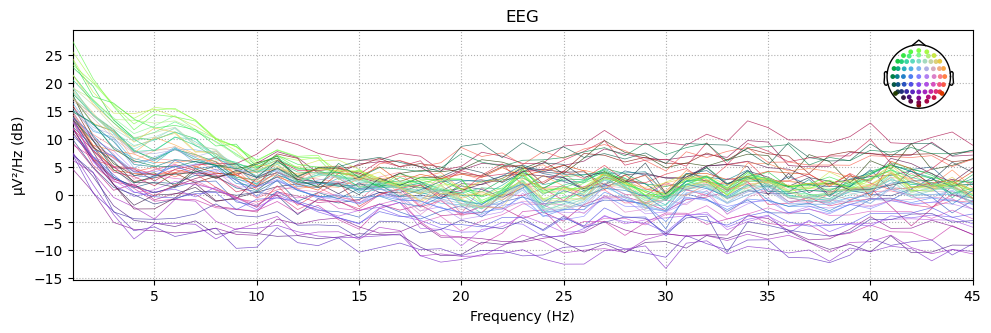

In [198]:
spectrum.plot(ci=None, show=False, average=False, spatial_colors=True)

Effective window size : 1.000 (s)


<MNELineFigure size 1000x350 with 0 Axes>

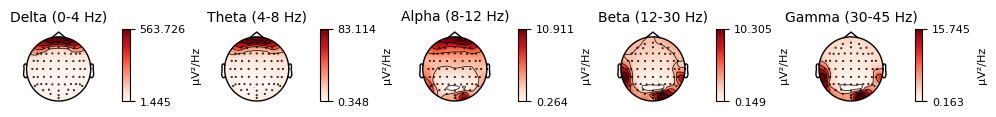

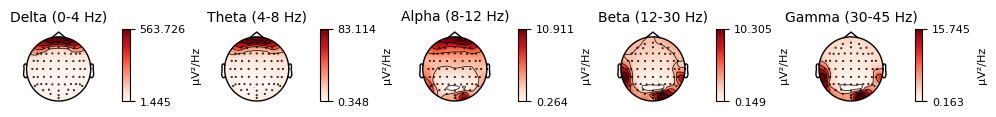

In [200]:
stopomap = d.compute_psd(fmin=0.5, fmax=45., picks='eeg', average='mean', n_fft=int(d.info['sfreq']))
plt.clf()
stopomap.plot_topomap(ch_type='eeg', agg_fun=np.median)

In [15]:
def compute_psd_bands(psds:np.array, freqs) -> np.array:
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 5.0],
                    "theta": [5.0, 8.0],
                    "alpha": [8.0, 13.0],
                    "sigma": [13.0, 16.0],
                    "beta": [16.0, 30.0]}
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)
    # Compute by bands
    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, (freqs >= fmin) & (freqs < fmax), :].mean(axis=1)
        X.append(psds_band.reshape(len(psds), 1, -1))
    Y = np.concatenate(X, axis=1)
    return Y # still lacking timestamps

In [ ]:
def psd_window(data, start:float, end:float):
    d = data.copy()
    d.crop(tmin=300, tmax=320)
    d.pick_channels([x for x in d.ch_names if '1-' in x or 'Status' in x])

## Align EEG / Watch
TODO : 
* Load both watches: check if difference in video = difference in tags
* Align both watches
* Align to EEG and check if timestamps start at start of second
* Cut to align to video
* Export - either as dataframe or as dictionary file containing data for both participant, sparse
* Compute band power?

In [18]:
vfolder = "221118_VPET"
mark = markers.loc[markers.file == vfolder].iloc[0]

In [19]:
mark['Watch p1'], mark['Watch p2']

(1.08, 2.92)

In [80]:
SRC_PATH = "/Users/eliot/Documents/projects/brainkt-expe/src"
sys.path.append(SRC_PATH)
# reading / writing textgrids
from audio_eeg_e4_sync import read_one_watch_data, _aggregate_one_watch

In [20]:
wfolder = os.path.join(e4_folder, vfolder)
wfiles = sorted(os.listdir(wfolder))
wfile_p1 = os.path.join(wfolder, wfiles[0])
wfile_p2 = os.path.join(wfolder, wfiles[1])
wfile_p1

'../data/empatica/221118_VPET/brainkt_221118_VPET_p1_VP_e4_A03CEF.zip'

In [209]:
watch_p1 = read_one_watch_data(wfile_p1)
watch_p2 = read_one_watch_data(wfile_p2)
watch_p1.keys()

dict_keys(['tags', 'HR', 'TEMP', 'BVP', 'EDA', 'ACC'])

In [210]:
#watch_p1['tags'] # corresponds to mark['Watch p1']
{   'Watch p1': watch_p1['tags'][0], 'Watch p2': watch_p2['tags'][0],
    'Mark diff': (watch_p2['tags'][0] - watch_p1['tags'][0]).total_seconds(), 
    'Video': mark['Watch p2'] - mark['Watch p1']
}

{'Watch p1': datetime.datetime(2022, 11, 28, 14, 51, 58, 450000),
 'Watch p2': datetime.datetime(2022, 11, 28, 14, 52, 16, 140000),
 'Mark diff': 17.69,
 'Video': 18.639999999999997}

In [189]:
mark

file                 221215_AGET
Start                        0.0
Watch p1                    0.88
Watch p2                    1.56
Clap                      142.88
Start Task 1               164.2
End Task 1               1074.88
End Task 2               2136.16
Stop                      2137.0
Actual End Task 1            NaN
Name: 27, dtype: object

In [405]:
watch_p1['ACC']

{'start': 1669218227.0,
 'fs': 32,
 'data':        ACC_0  ACC_1  ACC_2        time
 0        -68     -9     -1     0.00000
 1        -73    -15     -9     0.03125
 2        -61    -13      1     0.06250
 3        -61    -13      2     0.09375
 4        -60    -15      0     0.12500
 ...      ...    ...    ...         ...
 97681    -25     32     55  3052.53125
 97682    -25     25     58  3052.56250
 97683    -25     24     58  3052.59375
 97684    -26     20     59  3052.62500
 97685    -27     20     60  3052.65625
 
 [97686 rows x 4 columns]}

In [216]:
awatch, min_ts = _aggregate_one_watch(watch_p1)
awatch['time_abs'] = awatch.time.apply(lambda x: datetime.datetime.fromtimestamp(min_ts).replace(tzinfo=datetime.timezone.utc) + datetime.timedelta(seconds=x))
min_ts, datetime.datetime.fromtimestamp(min_ts).replace(tzinfo=datetime.timezone.utc)

(1669642791.0,
 datetime.datetime(2022, 11, 28, 14, 39, 51, tzinfo=datetime.timezone.utc))

In [217]:
awatch

,time,HR,TEMP,BVP,EDA,ACC_0,ACC_1,ACC_2,time_abs
0,0.000000,NaN,31.51,-0.0,0.0,53.0,9.0,-33.0,2022-11-28 14:39:51+00:00
1,0.015625,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,2022-11-28 14:39:51.015625+00:00
2,0.031250,NaN,NaN,-0.0,NaN,54.0,9.0,-32.0,2022-11-28 14:39:51.031250+00:00
3,0.046875,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,2022-11-28 14:39:51.046875+00:00
4,0.062500,NaN,NaN,-0.0,NaN,53.0,9.0,-33.0,2022-11-28 14:39:51.062500+00:00
...,...,...,...,...,...,...,...,...,...
191220,3003.000000,77.03,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-28 15:29:54+00:00
191221,3004.000000,77.03,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-28 15:29:55+00:00
191222,3005.000000,77.02,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-28 15:29:56+00:00
191223,3006.000000,77.00,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-28 15:29:57+00:00


In [218]:
awatch['time_abs'].iloc[0], watch_p1['tags'][0].replace(tzinfo=datetime.timezone.utc)

(Timestamp('2022-11-28 14:39:51+0000', tz='UTC'),
 datetime.datetime(2022, 11, 28, 14, 51, 58, 450000, tzinfo=datetime.timezone.utc))

Channels marked as bad:
['2-A31', '2-B25']


In [212]:
# Method 1: Drop everything before EEG start
awatch = awatch[awatch.time_abs >= ndata.info['meas_date']]
# Method 2: Annotate but datetime behaves weirdly for < 0 dates - using .totalseconds() to bypass this
# awatch['from_eeg_start'] = (awatch.time_abs.total_seconds() - ndata.info['meas_date'].total_seconds()).abs() 
# awatch['from_eeg_start'].min()

# Retime dataframe
awatch['time'] = awatch['time'] - awatch['time'].iloc[0]
(watch_p1['tags'][0].replace(tzinfo=datetime.timezone.utc) - awatch['time_abs'].iloc[0]).total_seconds()

-289.346875

Two methods:
* Drop everything before start of eeg - cons: if original EEG and needs to be padded, should be okay with modified EEG
* Annotate eeg start in data - cons: more annotations

In [151]:
awatch.time_abs[awatch.time_abs < data.info['meas_date']]

0              2022-12-15 11:43:25+00:00
1       2022-12-15 11:43:25.015625+00:00
2       2022-12-15 11:43:25.031250+00:00
3       2022-12-15 11:43:25.046875+00:00
4       2022-12-15 11:43:25.062500+00:00
                      ...               
59195   2022-12-15 11:58:49.921875+00:00
59196   2022-12-15 11:58:49.937500+00:00
59197   2022-12-15 11:58:49.953125+00:00
59198   2022-12-15 11:58:49.968750+00:00
59199   2022-12-15 11:58:49.984375+00:00
Name: time_abs, Length: 59200, dtype: datetime64[ns, UTC]

In [149]:
(awatch.time_abs - data.info['meas_date']).abs().min()

Timedelta('0 days 00:00:00')

In [138]:
delay_to_eeg = data.info['meas_date'] - datetime.datetime.fromtimestamp(min_ts).replace(tzinfo=datetime.timezone.utc)
#delay_to_eeg = data.info['meas_date'].timestamp() - min_ts # 8049??
delay_to_eeg = delay_to_eeg.total_seconds() # float(f"{delay_to_eeg.seconds}.{delay_to_eeg.microseconds}")

In [139]:
delay_to_eeg

925.0

In [415]:
ndata.info['meas_date'] - datetime.datetime.fromtimestamp(min_ts).replace(tzinfo=datetime.timezone.utc)

datetime.timedelta(seconds=1025, microseconds=377930)

In [414]:
ndata.info['meas_date']

datetime.datetime(2022, 11, 23, 17, 0, 52, 377930, tzinfo=datetime.timezone.utc)

In [421]:
awatch.head(30)

,time,HR,TEMP,BVP,EDA,ACC_0,ACC_1,ACC_2
0,0.000000,NaN,31.83,-0.00,0.000000,-68.0,-9.0,-1.0
1,0.015625,NaN,NaN,-0.00,NaN,NaN,NaN,NaN
2,0.031250,NaN,NaN,-0.00,NaN,-73.0,-15.0,-9.0
3,0.046875,NaN,NaN,-0.00,NaN,NaN,NaN,NaN
4,0.062500,NaN,NaN,-0.00,NaN,-61.0,-13.0,1.0
5,0.078125,NaN,NaN,-0.00,NaN,NaN,NaN,NaN
6,0.093750,NaN,NaN,-0.00,NaN,-61.0,-13.0,2.0
7,0.109375,NaN,NaN,-0.00,NaN,NaN,NaN,NaN
8,0.125000,NaN,NaN,-0.00,NaN,-60.0,-15.0,0.0
9,0.140625,NaN,NaN,-0.00,NaN,NaN,NaN,NaN


Checking time for all watches/eeg pairs
* Should be able to check watches startup order based on sign (should be same between both)

In [ ]:
vfolders = [vfolder for vfolder in sorted(os.listdir(video_path)) if os.path.isdir(os.path.join(video_path, vfolder))]
# For each file
watch_check = []
for i, vfolder in enumerate(vfolders):
    print(f"Analysing {i+1}/{len(vfolders)} {vfolder}", end="\t")
    try:
        # 0. Read files
        [date, group] = vfolder.split('_') 
        vaudio, vfs, raudio, rfs, data, mark, markers_idx = load_data(date, group)
        # 1. Align EEG
        audio_trig = get_audio_trig(vaudio, mark, vfs)
        dpt = check_durations(audio_trig["p2-spec_time"], markers_idx, data.info['sfreq'], precision=5e-2)
        ndata = trim_or_pad_eeg(data, dpt, mark.loc['Stop'])
        del data
        # 2. Read Watches
        wfolder = os.path.join(e4_folder, vfolder)
        wfiles = [x for x in sorted(os.listdir(wfolder)) if not 'DS_Store' in x]
        wfile_p1 = os.path.join(wfolder, wfiles[0])
        wfile_p2 = os.path.join(wfolder, wfiles[1])
        watch_p1 = read_one_watch_data(wfile_p1)
        watch_p2 = read_one_watch_data(wfile_p2)
        watch_check.append({   
            'Watch p1': watch_p1['tags'][0], 'Watch p2': watch_p2['tags'][0],
            'Mark diff': (watch_p2['tags'][0] - watch_p1['tags'][0]).total_seconds(), 
            'Video': mark['Watch p2'] - mark['Watch p1'],
            'EEG Start': ndata.info['meas_date'],
            'file': vfolder
        })
        del ndata
        del wfile_p1
        del wfile_p2
    except Exception as e:
        print('Issue, skipping', e)

watch_check = pd.DataFrame(watch_check)
watch_check

In [81]:
vfolders = [vfolder for vfolder in sorted(os.listdir(video_path)) if os.path.isdir(os.path.join(video_path, vfolder))]
# For each file
watches = {}
watches_tags = {}
for i, vfolder in enumerate(vfolders):
    print(f"Analysing {i+1}/{len(vfolders)} {vfolder}", end="\t")
    try:
        # 2. Read Watches
        wfolder = os.path.join(e4_folder, vfolder)
        wfiles = [x for x in sorted(os.listdir(wfolder)) if '.zip' in x] # brainkt_{date}_{group}_p{X}_{part}_{watchID}
        wfile_p1 = os.path.join(wfolder, wfiles[0])
        wfile_p2 = os.path.join(wfolder, wfiles[1])
        watch_p1 = read_one_watch_data(wfile_p1, )
        watch_p2 = read_one_watch_data(wfile_p2, )
        watches[vfolder] = {'p1': watch_p1.copy(), 'p2': watch_p2.copy()}
        watches_tags[vfolder] = {'p1': watch_p1['tags'], 'p2': watch_p2['tags']}
        print()
    except Exception as e:
        print('Issue, skipping', e)

Analysing 1/28 221116_CGLS	
Analysing 2/28 221117_TFGG	
Analysing 3/28 221118_GDNF	
Analysing 4/28 221118_VPET	
Analysing 5/28 221121_JPMC	
Analysing 6/28 221122_BDCC	
Analysing 7/28 221122_EBPT	
Analysing 8/28 221123_JFHB	
Analysing 9/28 221123_MMCM	
Analysing 10/28 221123_YAEB	
Analysing 11/28 221125_FDCC	
Analysing 12/28 221128_EMTR	
Analysing 13/28 221128_LBRA	
Analysing 14/28 221130_AMLB	
Analysing 15/28 221130_ASCS	
Analysing 16/28 221130_PCEF	
Analysing 17/28 221130_TFLH	
Analysing 18/28 221201_LIVS	
Analysing 19/28 221201_MMLM	
Analysing 20/28 221202_ELLD	
Analysing 21/28 221205_KMJF	
Analysing 22/28 221206_LKCR	
Analysing 23/28 221206_MMER	
Analysing 24/28 221207_LBMC	
Analysing 25/28 221207_SALT	
Analysing 26/28 221207_SLCB	
Analysing 27/28 221208_MBLB	
Analysing 28/28 221215_AGET	


In [75]:
def select_trig(p1:list, p2:list, ref_time=None):
    # if 0 value issue, if 1 value no brainer
    # if more than 1 value for one watch: takes the closest
    # if more than 1 value for both watches: takes the closest between the two and to a reference time (experiment start)
    comp = []
    for t1 in p1:
        for t2 in p2:
            comp.append({'t1':t1, 't2':t2, 'diff':abs(t2-t1)})
    comp = pd.DataFrame(comp)
    return comp

In [82]:
watches_tags

{'221116_CGLS': {'p1': [datetime.datetime(2022, 11, 16, 10, 15, 49, 980000)],
  'p2': [datetime.datetime(2022, 11, 16, 10, 15, 58, 80000)]},
 '221117_TFGG': {'p1': [datetime.datetime(2022, 11, 17, 10, 55, 1, 170000)],
  'p2': [datetime.datetime(2022, 11, 17, 10, 54, 50, 520000),
   datetime.datetime(2022, 11, 17, 11, 28, 57, 500000)]},
 '221118_GDNF': {'p1': [datetime.datetime(2022, 11, 18, 17, 1, 44, 310000)],
  'p2': [datetime.datetime(2022, 11, 18, 17, 1, 22, 230000)]},
 '221118_VPET': {'p1': [datetime.datetime(2022, 11, 18, 14, 3, 28, 670000),
   datetime.datetime(2022, 11, 18, 14, 40, 21, 920000)],
  'p2': [datetime.datetime(2022, 11, 18, 13, 45, 57, 700000),
   datetime.datetime(2022, 11, 18, 14, 3, 29, 380000)]},
 '221121_JPMC': {'p1': [datetime.datetime(2022, 11, 21, 13, 52, 40, 830000)],
  'p2': [datetime.datetime(2022, 11, 21, 13, 52, 44, 950000)]},
 '221122_BDCC': {'p1': [datetime.datetime(2022, 11, 22, 13, 59, 5, 160000)],
  'p2': [datetime.datetime(2022, 11, 22, 13, 59, 9,

In [78]:
select_trig(watches_tags['221118_VPET']['p1'], ['221118_VPET']['p2'])

<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_21455/3287588773.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  select_trig(watches_tags['221118_VPET']['p1'], ['221118_VPET']['p2'])
/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_21455/3287588773.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  select_trig(watches_tags['221118_VPET']['p1'], ['221118_VPET']['p2'])
/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_21455/3287588773.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  select_trig(watches_tags['221118_VPET']['p1'], ['221118_VPET']['p2'])
/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_21

TypeError: list indices must be integers or slices, not str

In [74]:
pd.DataFrame(watches_tags).T

,p1,p2
221116_CGLS,[2022-11-16 10:15:49.980000],[2022-11-16 10:15:58.080000]
221117_TFGG,[2022-11-17 10:55:01.170000],"[2022-11-17 10:54:50.520000, 2022-11-17 11:28:..."
221118_GDNF,[2022-11-18 17:01:44.310000],[2022-11-18 17:01:22.230000]
221118_VPET,"[2022-11-18 14:03:28.670000, 2022-11-18 14:40:...","[2022-11-18 13:45:57.700000, 2022-11-18 14:03:..."
221121_JPMC,[2022-11-21 13:52:40.830000],[2022-11-21 13:52:44.950000]
221122_BDCC,[2022-11-22 13:59:05.160000],[2022-11-22 13:59:09.950000]
221122_EBPT,[2022-11-22 16:54:42.200000],[2022-11-22 16:54:46.440000]
221123_JFHB,[2022-11-23 09:35:50.270000],[2022-11-23 09:35:51.800000]
221123_MMCM,[2022-11-23 14:11:00],[2022-11-23 14:11:05.660000]
221123_YAEB,[2022-11-23 16:56:06.800000],[2022-11-23 16:56:10.450000]


VPET : issue 2 tags - need to take 2nd? maybe? need check?

In [25]:
'ET', datetime.datetime.fromtimestamp(1668775557.70), datetime.datetime.fromtimestamp(1668776609.38)

('ET',
 datetime.datetime(2022, 11, 18, 13, 45, 57, 700000),
 datetime.datetime(2022, 11, 18, 14, 3, 29, 380000))

In [26]:
'VP', datetime.datetime.fromtimestamp(1668776608.67), datetime.datetime.fromtimestamp(1668778821.92)

('VP',
 datetime.datetime(2022, 11, 18, 14, 3, 28, 670000),
 datetime.datetime(2022, 11, 18, 14, 40, 21, 920000))

In [28]:
1668776609.38 - 1668776608.67

0.7100000381469727

Note: need to use the delay between the two (audios in) videos to align both of those too.

In [56]:
watch_check[['Watch p1','Watch p2']].min(axis=1).apply(lambda x: float(f"{x.second}.{x.microsecond}")) - watch_check['EEG Start'].apply(lambda x: float(f"{x.second}.{x.microsecond}"))

0    37.343281
1   -32.450664
2    50.411426
3   -42.730137
4    10.655078
5     8.292559
6     8.051270
7     2.435270
8     3.136094
9    -5.300234
dtype: float64

In [61]:
watch_check[['Watch p1','Watch p2']].min(axis=1).dt.time

TypeError: unsupported Type RangeIndex

In [64]:
watch_check[['Watch p1','Watch p2']].min(axis=1) / np.timedelta64(1, 's')

TypeError: cannot perform __truediv__ with this index type: DatetimeArray